# Scrap de datos

# Lectura del archivo

In [8]:
import pandas as pd

# Load the data from the provided text file
data = pd.read_csv('teenagers_posts_2024-07-12_15-02-29.txt', delimiter='\t', header=None, names=['post', 'label'])


# Txt to csv file

In [6]:
data.to_csv('teenagers_posts.csv', index=False)

# Creación del DataFrame

In [45]:
# Load CSV into DataFrame
file_path = 'teenagers_posts.csv'
data = pd.read_csv(file_path)

# Merge 'title' and 'selftext' into a new column 'merged_text'
data['merged_text'] = data['title'] + ' ' + data['selftext']

# Drop 'title' and 'selftext' columns
data.drop(columns=['title', 'selftext'], inplace=True)

# Rearrange columns
cols = data.columns.tolist()
cols = ['merged_text'] + [col for col in cols if col != 'merged_text']
data = data[cols]

# Rename 'merged_text' column to 'posts'
data.rename(columns={'merged_text': 'posts'}, inplace=True)

# Save modified DataFrame back to CSV file
modified_file_path = 'teenagers_posts_modified.csv'
data.to_csv(modified_file_path, index=False)

data.head()

,posts,label
0,Is it gayer to have a relationship with a man ...,NaN
1,Quitting porn day 1 I don’t even watch porn bu...,NaN
2,nah yeah mudcrabs are GIANT like genuinely the...,NaN
3,I feel like I'm gonna tranced to a different r...,NaN
4,does anyone else get horrifically down atrocio...,NaN


# Limpieza de datos

In [46]:
import re

# Remove duplicates and handle missing values
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

# Function to remove special characters, URLs, and unnecessary whitespace
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers (retain only letters)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Normalize spaces to single space and convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip().lower()
    
    return text

# Load CSV into DataFrame
file_path = './teenagers_posts_modified.csv'
data = pd.read_csv(file_path)

# Apply clean_text function to 'posts' column
data['posts'] = data['posts'].apply(clean_text)

# Save cleaned DataFrame back to CSV file
cleaned_file_path = 'teenagers_cleaned.csv'
data.to_csv(cleaned_file_path, index=False)

# Print first few rows to verify
print(data.head())

                                               posts  label
0  is it gayer to have a relationship with a man ...    NaN
1  quitting porn day i dont even watch porn but e...    NaN
2  nah yeah mudcrabs are giant like genuinely the...    NaN
3  i feel like im gonna tranced to a different re...    NaN
4  does anyone else get horrifically down atrocio...    NaN


# Etiquetado del Dataset

Criteria for depression labeling:
+ Expressions of persistent sadness, hopelessness, or emptiness.
+ Mentions of losing interest in activities once enjoyed.
+ Statements indicating feelings of worthlessness or excessive guilt.
+ Posts discussing fatigue, low energy, or sleep disturbances related to mood.
+ Descriptions of difficulty concentrating or making decisions.
+ Mentions of significant weight changes or appetite changes due to mood.

Criteria for suicidal tendencies labeling:
+ Explicit mentions of wanting to die or commit suicide.
+ Statements indicating plans or methods for committing suicide.
+ Posts expressing a desire to escape life or end one's suffering.
+ References to self-harm with suicidal intent.
+ Expressions of severe despair with no perceived way out.

Critera for neutral/other posts
+ Posts that do not express any symptoms or indicators of depression or suicidal tendencies.
+ General discussions, questions, or statements about daily life, interests, or activities.
+ Positive or neutral expressions, including casual conversations, jokes, or light-hearted content.

Labeling:
+ No Depression / No Suicidal Thoughts:
Text does not indicate any signs of depression or suicidal thoughts.

+ Mild Depression:
Text shows subtle signs or mild expressions of sadness, hopelessness, or lack of interest.

+ Moderate Depression:
Text indicates moderate levels of depressive symptoms, such as persistent sadness, decreased energy, or changes in sleep or appetite.

+ Severe Depression:
Text reflects severe depressive symptoms, including intense feelings of despair, significant loss of interest in activities, or thoughts of worthlessness.

+ Mild Suicidal Thoughts:
Text contains passive or fleeting thoughts about death or suicide without specific plans or intent.

+ Moderate Suicidal Thoughts:
Text includes more persistent or frequent thoughts about death or suicide, sometimes with vague plans or ideation.

+ Severe Suicidal Thoughts:
Text indicates intense and persistent thoughts of suicide, often with specific plans, intent, or preparatory behaviors.

+ Positive / Coping:
Text shows positive coping mechanisms, resilience, or strategies for managing stress or difficult emotions.

+ Mixed Features:
Text contains elements of both depressive symptoms and suicidal thoughts, which may vary in intensity or co-occurrence.

+ Uncertain / Ambiguous: Text is unclear or ambiguous in terms of emotional state or symptoms related to depression or suicidal thoughts.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [19]:
data = pd.read_csv('teenagers_cleaned.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vposts  997 non-null    object 
 1   label   0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 15.7+ KB


In [74]:
# Define labels 
labels = {
    'Positive': ['happy', 'content', 'normal', 'satisfied', 'positive', 'joyful', 'cheerful', 'carefree', 'peaceful', 'calm', 'stable', 'balanced', 'serene', 'hopeful', 'fulfilled', 'optimistic', 'lively', 'energetic', 'vibrant', 'thriving', 'well-adjusted', 'resilient', 'upbeat', 'buoyant', 'enthusiastic', 'lively', 'elated','resilient', 'coping', 'managing stress', 'problem-solving', 'optimistic', 'hopeful', 'supportive relationships', 'exercise', 'hobbies'],
    'Mixed Features': ['conflicted', 'ambivalent', 'up and down', 'uncertain', 'mood swings', 'coping and struggling', 'swinging emotions','unsure', 'confused', 'unclear', 'mixed feelings', 'uncertain emotions', 'difficult to understand', 'unclear thoughts'],
    'Depression/Suicidal Thoughts': ['sad', 'blue', 'down', 'low', 'unhappy', 'gloomy', 'discouraged', 'disinterested', 'unmotivated', 'indifferent', 'apathetic', 'listless', 'melancholic', 'withdrawn', 'quiet', 'mellow', 'subdued', 'contemplative', 'introspective', 'reflective', 'somber', 'despondent', 'forlorn', 'morose', 'melancholy','depressed', 'hopeless', 'helpless', 'tired', 'fatigued', 'irritable', 'restless', 'agitated', 'anxious', 'stressed', 'overwhelmed', 'burdened', 'somber', 'pensive', 'brooding', 'introspective', 'moody', 'despondent', 'troubled', 'disheartened','moody', 'despondent', 'troubled', 'disheartened', 'dejected', 'discouraged', 'bleak', 'dismal', 'wretched', 'distressed', 'haunted', 'despair', 'worthlessness', 'guilt', 'emptiness', 'numbness', 'isolation', 'loneliness', 'misery', 'anguish', 'sorrow', 'grief', 'devastated', 'devastated', 'anguish', 'agony', 'hopeless', 'suicidal', 'inconsolable', 'apathetic', 'thoughts','death', 'die', 'end it', 'disappear', 'escape', 'peaceful', 'painless', 'no reason to live','suicidal', 'planning', 'thinking about death', 'ways to die', 'unbearable pain', 'ending life', 'giving up','suicide', 'intent', 'method', 'preparation', 'goodbye letters', 'final arrangements', 'goodbye messages', 'suicide note'],
}

In [79]:
# Flatten the labels dictionary
flattened_labels = {word: category for category, words in labels.items() for word in words}

# Function to categorize labels based on presence in text
def categorize_label(text):
    text = text.lower()  # Ensure the text is in lowercase for matching
    words = text.split()
    
    for category, keywords in labels.items():
        if any(word in words for word in keywords):
            return category
    return 'Neutral'  # Return 'Neutral' if no match found

# Read the CSV file into a DataFrame
file_path = 'teenagers_cleaned.csv'
data = pd.read_csv(file_path)

# Apply label categorization function
data['label'] = data['vposts'].apply(lambda x: categorize_label(x))

# Save the DataFrame with the new labels back to a CSV file (optional)
output_file_path = 'teenagers_labeled.csv'
data.to_csv(output_file_path, index=False)

# Print the first few rows of the DataFrame to check the result
print(data.head())
print('\n')
data.info()
print('\n\n', data['label'].value_counts())

                                              vposts           label
0  is it gayer to have a relationship with a man ...         Neutral
1  quitting porn day i dont even watch porn but e...         Neutral
2  nah yeah mudcrabs are giant like genuinely the...         Neutral
3  i feel like im gonna tranced to a different re...         Neutral
4  does anyone else get horrifically down atrocio...  Mixed Features


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   vposts  997 non-null    object
 1   label   997 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


 label
Neutral                         875
Depression/Suicidal Thoughts     77
Positive                         35
Mixed Features                   10
Name: count, dtype: int64


# Tokenización

In [80]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

ModuleNotFoundError: No module named 'nltk'

In [27]:
# Tokenization and stop word removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

data['processed_text'] = data['post'].apply(preprocess_text)


# Análisis exploratorio y Visualización de datos inicial

IndexError: index 0 is out of bounds for axis 0 with size 0

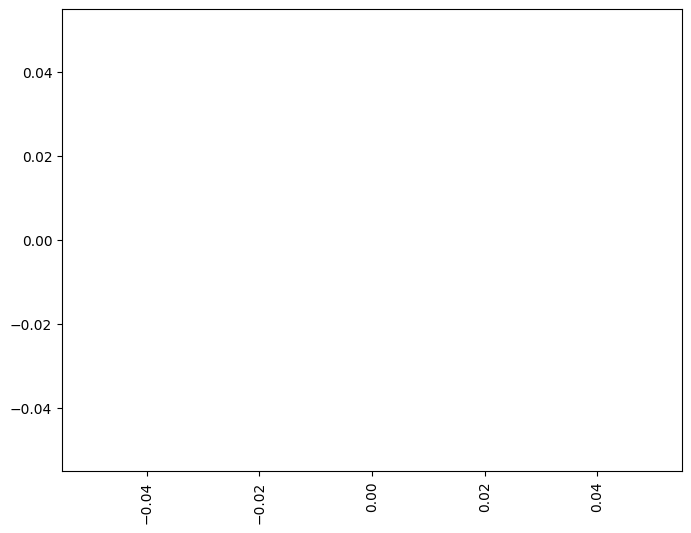

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Generate word cloud for each sentiment category
for label in data['label'].unique():
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data[data['label'] == label]['processed_text']))
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {label} Posts')
    plt.axis('off')
    plt.show()


# División de datos, entrenamiento y evaluación del modelo

In [ ]:
# Python code for data splitting, model training, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['label'], test_size=0.2, random_state=42)

# Build a pipeline for model training and evaluation
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
